# The Echo Chamber Simulator - Evaluation

## Setup

In [1]:
dataset = 'synth_3_comms'
model = 'DistMult'

user_modes = ['epistemic', 'ideological']
rec_modes = ['random', 'ranked']

target_epoch = None

long_tail_cutoff = 20
degree_rank_cutoff = 50

In [2]:
def get_label(user_mode, rec_mode):
    if user_mode == 'epistemic':
        label_1 = r'$\mathcal{L}_1$'
    elif user_mode == 'ideological':
        if community_info['ideological'].min() == 1:
            label_1 = r'$\mathcal{L}_2$'
        else:
            label_1 = r'$\mathcal{L}_{1\vert2}$'

    if rec_mode == 'random':
        label_2 = 'Rand.'
    else:
        label_2 = 'Pers.'

    return '{} x {}'.format(label_1, label_2)

In [3]:
import sys
sys.path.append('../src')

import os
import joypy

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict

from graph import homophily, performance as perf
from utils import bidict

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'dataset', 'processed', dataset)

/home/tim/miniconda3/envs/echo/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
community_info = pd.read_csv(os.path.join(data_dir, 'community_info.csv'), index_col='id')
community_info

,label,ideological,count
id,,,
43195,red,1,520
43196,green,0,4100
43197,blue,1,520


In [5]:
colors = {
    'target': '#038db2',
    'initial': '#45aab4',
} 

for user_mode in user_modes:
    for rec_mode in rec_modes:
        label = get_label(user_mode, rec_mode)
        
        if user_mode == 'epistemic' and rec_mode == 'random':
            colors[label] = '#EC5200'#'#7d4282'
        elif user_mode == 'epistemic' and rec_mode == 'ranked':
            colors[label] = '#A54C0B' #'#bc5299'
        elif user_mode == 'ideological' and rec_mode == 'random':
            colors[label] = '#007B6E' #'#c83e6a'
        elif user_mode == 'ideological' and rec_mode == 'ranked':
            colors[label] = '#086D4E' #'#a70000'
        else:
            colors[label] = tuple(np.random.uniform(low=0, high=1, size=3))

In [6]:
log_dirs = defaultdict(list)
for rec_mode in rec_modes:
    for user_mode in user_modes:
        label = get_label(user_mode, rec_mode)
        save_path = os.path.join(parent_dir, 'log', dataset, user_mode, rec_mode, model)     
     
        try:
            sorted_dirs = sorted(os.listdir(save_path))
            #log_dir = os.path.join(save_path, sorted_dirs[-1])
            print(sorted_dirs)
            
            for d in sorted_dirs:
                log_dir = os.path.join(save_path, d)
                log_dirs[label].append(log_dir)
            #log_dir = os.path.join(save_path, sorted_dirs[0])
            #log_dirs[label] = log_dir
        except FileNotFoundError:
            print("No directory found for {}".format(label))
            
print(log_dirs)

['1671297756.5055144', '1671390675.0387974', '1671471544.696119']
['1671287400.2973092', '1671380153.9654372', '1671459934.097082']
['1671280086.471857', '1671372696.5617404', '1671452267.2474864']
['1671271898.7852602', '1671364615.9744673', '1671443865.4738665']
defaultdict(<class 'list'>, {'$\\mathcal{L}_1$ x Rand.': ['/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/epistemic/random/DistMult/1671297756.5055144', '/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/epistemic/random/DistMult/1671390675.0387974', '/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/epistemic/random/DistMult/1671471544.696119'], '$\\mathcal{L}_{1\\vert2}$ x Rand.': ['/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/ideological/random/DistMult/1671287400.2973092', '/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/ideological/random/DistMult/1671380153.9654372', '/home/tim/git-projects/2022-Echo-Chamber/log/synth_3_comms/ideological/random/DistMult/1671459934.0

In [7]:
print('[Completed Epochs]')

min_len = 2

logs = defaultdict(lambda: defaultdict(list))

for condition, log_dirs_ in log_dirs.items():
    temp_logs = []
    for log_dir in log_dirs_:
        df_log = pd.read_csv(os.path.join(log_dir, 'simulation.csv'), index_col=0)
        num_epochs = df_log.shape[0]
        print(condition, num_epochs)

        # Temporary: calculate alternative polarization    
        for community in community_info.index:
            size = df_log['size_{}'.format(community)]
            total_size = df_log['num_nodes']
            pol = df_log['pol_{}'.format(community)]
            df_log['norm_pol_{}'.format(community)] = pol * (size / total_size)
            #df_log['norm_pol_{}'.format(community)] = pol

            hom = df_log['homophily_{}'.format(community)]
            df_log['norm_homophily_{}'.format(community)] = hom * (size / total_size)
            #df_log['norm_homophily_{}'.format(community)] = hom

        test = df_log[['homophily_{}'.format(c) for c in community_info.index]]
        test[test == 0] = np.nan

        test = test.mean(axis=1)

        df_log['homophily_alt'] = test
        
        test = df_log[[c for c in df_log.columns if 'norm_homophily' in c]]
        df_log['norm_homophily_alt'] = test.sum(axis=1)

        test = df_log[[c for c in df_log.columns if 'norm_pol' in c]]
        df_log['norm_pol_alt'] = test.sum(axis=1)

        temp_logs.append(df_log)
        
    
    df_concat = pd.concat(temp_logs)
    #mean_df = mean_df.mean(axis=1)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.std()
    logs[condition]['mean'] = by_row_index.mean()
    logs[condition]['std'] = by_row_index.std()

if target_epoch is None:      
    target_epoch = np.amin([logs[c]['mean'].shape[0] for c in logs])

print("\n[Target Epoch] {}".format(target_epoch))

/home/tim/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/tim/miniconda3/envs/echo/lib/python3.7/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


[Completed Epochs]
$\mathcal{L}_1$ x Rand. 100
$\mathcal{L}_1$ x Rand. 100
$\mathcal{L}_1$ x Rand. 100
$\mathcal{L}_{1\vert2}$ x Rand. 100
$\mathcal{L}_{1\vert2}$ x Rand. 100
$\mathcal{L}_{1\vert2}$ x Rand. 100
$\mathcal{L}_1$ x Pers. 100
$\mathcal{L}_1$ x Pers. 100
$\mathcal{L}_1$ x Pers. 100
$\mathcal{L}_{1\vert2}$ x Pers. 100
$\mathcal{L}_{1\vert2}$ x Pers. 100
$\mathcal{L}_{1\vert2}$ x Pers. 100

[Target Epoch] 100


## Load Starting User Graph

In [8]:
starting_user_graph = nx.read_gexf(os.path.join(data_dir, 'user_graph.gexf'))
starting_community_mapper = bidict(nx.get_node_attributes(starting_user_graph, 'community'))

starting_degree = np.mean([x[1] for x in starting_user_graph.degree()])

In [9]:
overview = defaultdict(lambda: defaultdict())
overview['num_edges']['initial'] = starting_user_graph.number_of_edges()
overview['homophily']['initial'] = homophily(starting_user_graph, starting_community_mapper.inverse)['global']
overview['modularity']['initial'] = nx.algorithms.community.quality.modularity(starting_user_graph, list(starting_community_mapper.inverse.values()))
overview['degree_sequence']['initial'] = sorted([d for n, d in starting_user_graph.degree()], reverse=True)

degree_hist = np.unique(overview['degree_sequence']['initial'], return_counts=True)
overview['degree_hist']['initial'] = (degree_hist[0][:long_tail_cutoff], degree_hist[1][:long_tail_cutoff])

## Load Target User Graph

In [10]:
try:
    target_user_graph = nx.read_gexf(os.path.join(data_dir, 'target_user_graph.gexf'))
    target_community_mapper = bidict(nx.get_node_attributes(target_user_graph, 'community'))

    target_degree = np.mean([x[1] for x in target_user_graph.degree()])
except FileNotFoundError:
    print('Target User Graph not found. Defaulting...')
    target_user_graph = None

Target User Graph not found. Defaulting...


In [11]:
if target_user_graph is not None:
    overview['num_edges']['target'] = target_user_graph.number_of_edges()
    overview['homophily']['target'] = homophily(target_user_graph, target_community_mapper.inverse)['global']
    overview['modularity']['target'] = nx.algorithms.community.quality.modularity(target_user_graph, list(target_community_mapper.inverse.values()))
    overview['degree_sequence']['target'] = sorted([d for n, d in target_user_graph.degree()], reverse=True)
    
    degree_hist = np.unique(overview['degree_sequence']['target'], return_counts=True)
    overview['degree_hist']['target'] = (degree_hist[0][:long_tail_cutoff], degree_hist[1][:long_tail_cutoff])

# Load Condition User Graphs

In [12]:
overview_episodes = {}

for condition, log_df in logs.items():
    if target_user_graph is None:
        overview_episodes[condition] = target_epoch
    else:
        min_diff = None
        min_idx = None
        sub_logs = log_df['mean'].iloc[:target_epoch]
        num_edges_series = sub_logs['num_edges']

        for i, num_edges in num_edges_series.iteritems():
            if min_diff is None or abs(num_edges - target_num_edges) < min_diff:

                min_diff = abs(num_edges - target_num_edges)
                min_idx = i
        overview_episodes[condition] = min_idx

overview_episodes

{'$\\mathcal{L}_1$ x Rand.': 100,
 '$\\mathcal{L}_{1\\vert2}$ x Rand.': 100,
 '$\\mathcal{L}_1$ x Pers.': 100,
 '$\\mathcal{L}_{1\\vert2}$ x Pers.': 100}

In [13]:
for condition, log_dir in log_dirs.items():
    episode = overview_episodes[condition]
    user_graph = nx.read_gexf(os.path.join(log_dir[0], "user_graph_{}.gexf".format(episode)), node_type=str)
    community_mapper = bidict(nx.get_node_attributes(user_graph, 'community'))
    
    overview['num_edges'][condition] = user_graph.number_of_edges()
    overview['homophily'][condition] = homophily(user_graph, community_mapper.inverse)['global']
    overview['modularity'][condition] = nx.algorithms.community.quality.modularity(user_graph, list(community_mapper.inverse.values()))
    overview['degree_sequence'][condition] = sorted([d for n, d in user_graph.degree()], reverse=True)
    
    degree_hist = np.unique(overview['degree_sequence'][condition], return_counts=True)
    overview['degree_hist'][condition] = (degree_hist[0][:long_tail_cutoff], degree_hist[1][:long_tail_cutoff])

In [14]:
overview_df = pd.DataFrame(overview)
overview_df

,num_edges,homophily,modularity,degree_sequence,degree_hist
initial,32078,0.818092,0.248624,"[1613, 951, 682, 666, 598, 510, 465, 365, 365,...","([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
$\mathcal{L}_1$ x Rand.,110029,1.000000,0.000000,"[4110, 4093, 3890, 3824, 3790, 3365, 3143, 297...","([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, ..."
$\mathcal{L}_{1\vert2}$ x Rand.,110322,1.000000,0.000000,"[4211, 4121, 4010, 3868, 3705, 3546, 3526, 287...","([12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, ..."
$\mathcal{L}_1$ x Pers.,153000,0.748565,0.052981,"[2318, 2303, 1767, 1752, 1750, 1736, 1630, 160...","([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, ..."
$\mathcal{L}_{1\vert2}$ x Pers.,145057,0.938198,0.402785,"[1583, 1452, 1336, 1289, 1256, 1176, 1171, 115...","([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, ..."


## 1. Overview

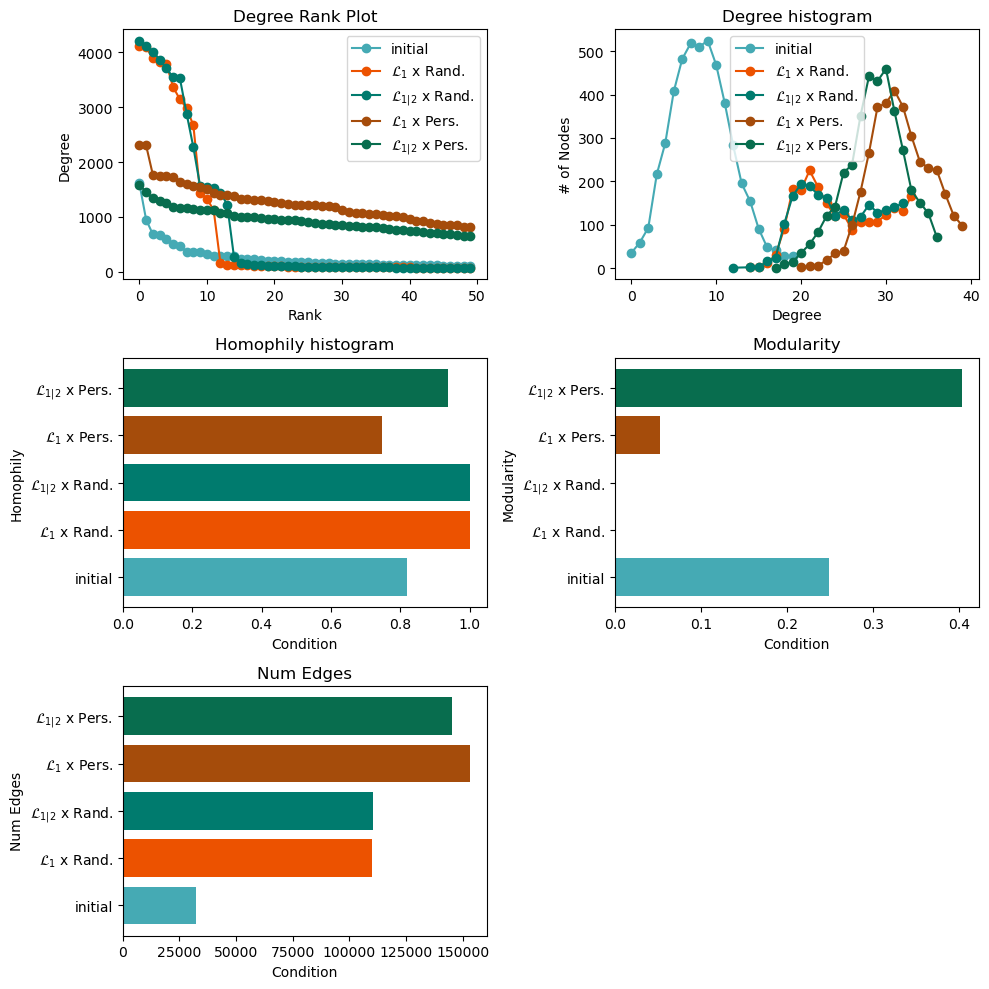

In [15]:
fig = plt.figure("Overview", figsize=(10, 10))
axgrid = fig.add_gridspec(3, 2)

''' Degree Rank Plot '''
ax1 = fig.add_subplot(axgrid[0, 0])
ax1.set_title("Degree Rank Plot")

''' Degree Histogram '''
ax2 = fig.add_subplot(axgrid[0, 1])
ax2.set_title("Degree histogram")

for _, row in overview_df.iterrows():
    color = tuple(np.random.uniform(low=0, high=1, size=3))
    ax1.plot(row['degree_sequence'][:degree_rank_cutoff], c=colors[row.name], marker="o", label=row.name)
    ax2.plot(*row['degree_hist'], marker="o", c=colors[row.name], label=row.name)    

ax3 = fig.add_subplot(axgrid[1, 0])
ax3.set_title("Homophily histogram")
ax3.set_xlabel("Condition")
ax3.set_ylabel("Homophily")
#colors = [tuple(np.random.uniform(low=0, high=1, size=3)) for _ in range(len(homophily_dict))]
ax3.barh(overview_df.index, overview_df['homophily'], color=[colors[c] for c in overview_df.index])

ax4 = fig.add_subplot(axgrid[1, 1])
ax4.set_title("Modularity")
ax4.set_xlabel("Condition")
ax4.set_ylabel("Modularity")
#colors = [tuple(np.random.uniform(low=0, high=1, size=3)) for _ in range(len(num_edges_dict))]
ax4.barh(overview_df.index, overview_df['modularity'], color=[colors[c] for c in overview_df.index])

ax4 = fig.add_subplot(axgrid[2, 0])
ax4.set_title("Num Edges")
ax4.set_xlabel("Condition")
ax4.set_ylabel("Num Edges")
#colors = [tuple(np.random.uniform(low=0, high=1, size=3)) for _ in range(len(num_edges_dict))]
ax4.barh(overview_df.index, overview_df['num_edges'], color=[colors[c] for c in overview_df.index])

ax1.legend()
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2.legend()
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")
fig.tight_layout()
plt.show()

In [16]:
from matplotlib.transforms import Bbox
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

## 2. Detailed Output

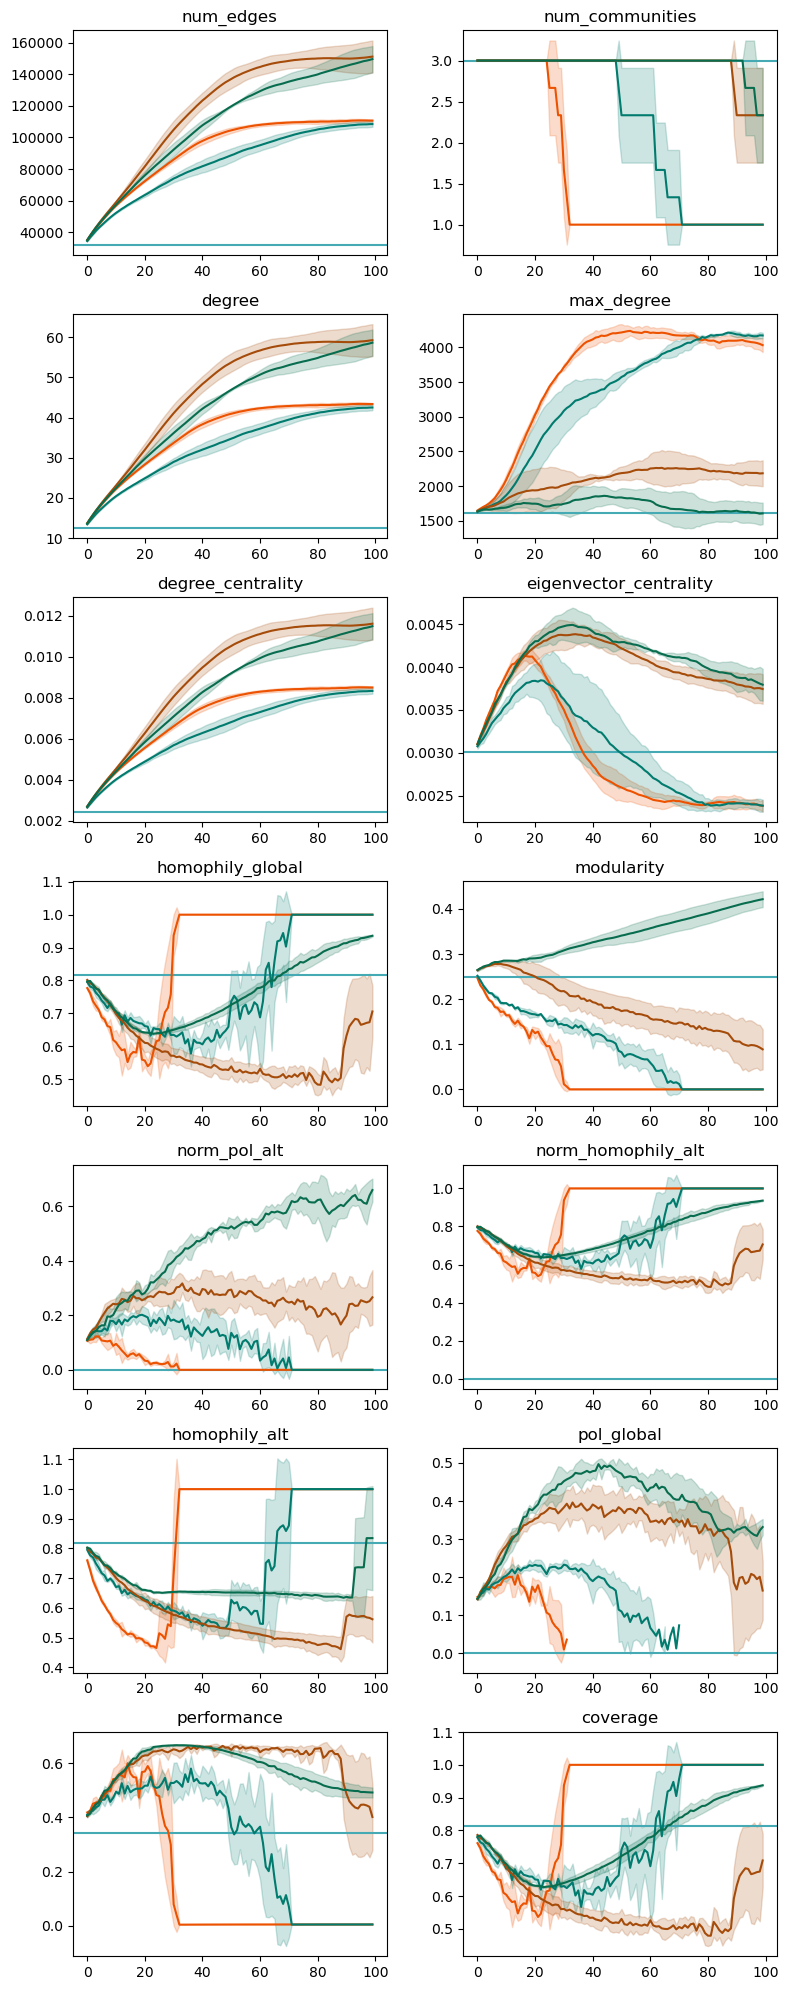

In [17]:
fig = plt.figure("Detail", figsize=(8, 20))
axgrid = fig.add_gridspec(7, 2)

def add_subplot(metric, x, y, initial, target, save=False, log_scale=False, sci=False, show_legend=False):
    ax = fig.add_subplot(axgrid[x, y])
    ax.set_title(metric)
    if log_scale:
        ax.set_yscale('log')
        
    if sci:
        ax.ticklabel_format('sci')

    ax.axhline(y=initial, color=colors['initial'], linestyle='-', label='initial')
    if target_user_graph is not None:
        ax.axhline(y=target, color=colors['target'], linestyle='-', label='target')

    df_mean = pd.DataFrame(dict([(c, df['mean'][metric].iloc[:target_epoch]) for c, df in logs.items()]))
    df_std = pd.DataFrame(dict([(c, df['std'][metric].iloc[:target_epoch]) for c, df in logs.items()]))
    for condition in df_mean:
        ax.plot(df_mean[condition], c=colors[condition], label=condition)
        ax.fill_between(range(100), df_mean[condition]-df_std[condition], df_mean[condition]+df_std[condition], alpha=0.2, edgecolor=colors[condition], facecolor=colors[condition])
        
    if save:
        save_path = os.path.join(parent_dir, 'log', dataset, 'evaluation', metric)
        save_fig = plt.figure(metric, figsize=(4, 4))
        
        plt.axhline(y=initial, color=colors['initial'], linestyle='-', label='initial')
        if target_user_graph is not None:
            save_fig.axhline(y=target, color=colors['target'], linestyle='-', label='target')

        for condition in df_mean:
            plt.plot(df_mean[condition], c=colors[condition], label=condition)
            plt.fill_between(range(100), df_mean[condition]-df_std[condition], df_mean[condition]+df_std[condition], alpha=0.2, edgecolor=colors[condition], facecolor=colors[condition])
        if show_legend:
            plt.legend()
        #save_fig.tight_layout()
        save_fig.savefig(save_path, dpi=300)

        
add_subplot('num_edges', 0, 0, 
            initial=len(starting_user_graph.edges()), 
            target=len(target_user_graph.edges()) if target_user_graph is not None else None)

add_subplot('num_communities', 0, 1,
           initial=len(starting_community_mapper.inverse),
           target=len(target_community_mapper.inverse) if target_user_graph is not None else None)
    
add_subplot('degree', 1, 0,
           initial=np.mean([x[1] for x in starting_user_graph.degree()]),
           target=np.mean([x[1] for x in target_user_graph.degree()]) if target_user_graph is not None else None,
           show_legend=True)    
    
add_subplot('max_degree', 1, 1,
           initial=sorted(starting_user_graph.degree, key=lambda x: x[1], reverse=True)[0][1],
           target=sorted(target_user_graph.degree, key=lambda x: x[1], reverse=True)[0][1] if target_user_graph is not None else None)    

add_subplot('degree_centrality', 2, 0,
           initial=np.mean(list(nx.degree_centrality(starting_user_graph).values())),
           target=np.mean(list(nx.degree_centrality(target_user_graph).values())) if target_user_graph is not None else None)  

add_subplot('eigenvector_centrality', 2, 1,
           initial=np.mean(list(nx.eigenvector_centrality(starting_user_graph).values())),
           target=np.mean(list(nx.eigenvector_centrality(target_user_graph).values())) if target_user_graph is not None else None)  

add_subplot('homophily_global', 3, 0,
           initial=overview['homophily']['initial'],
           target=overview['homophily']['target'] if target_user_graph is not None else None)  

add_subplot('modularity', 3, 1,
           initial=overview['modularity']['initial'],
           target=overview['modularity']['target'] if target_user_graph is not None else None)  

add_subplot('norm_pol_alt', 4, 0,
           initial=0,
           target=0,
           log_scale=False) 

add_subplot('norm_homophily_alt', 4, 1,
           #initial=overview['homophily']['initial'],
           initial=0,
           target=0)

add_subplot('homophily_alt', 5, 0,
           #initial=overview['homophily']['initial'],
           initial=overview['homophily']['initial'],
           target=0) 

add_subplot('pol_global', 5, 1,
           #initial=overview['homophily']['initial'],
           initial=0,
           target=0) 

add_subplot('performance', 6, 0,
           initial=perf(starting_user_graph, list(starting_community_mapper.inverse.values())),
           target=perf(target_user_graph, list(target_community_mapper.inverse.values())) if target_user_graph is not None else None)  

add_subplot('coverage', 6, 1,
           initial=nx.algorithms.community.quality.coverage(starting_user_graph, list(starting_community_mapper.inverse.values())),
           target=nx.algorithms.community.quality.coverage(target_user_graph, list(target_community_mapper.inverse.values())) if target_user_graph is not None else None)  


#plt.legend()
#plt.savefig(os.path.join(parent_dir, 'num_edges.png'), dpi=300)
fig.tight_layout()
plt.show()

# 3. PCA

In [18]:
import torch
import collections
from utils import bidict
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

       label  ideological  count
id                              
43195    red            1    520
43196  green            0   4100
43197   blue            1    520


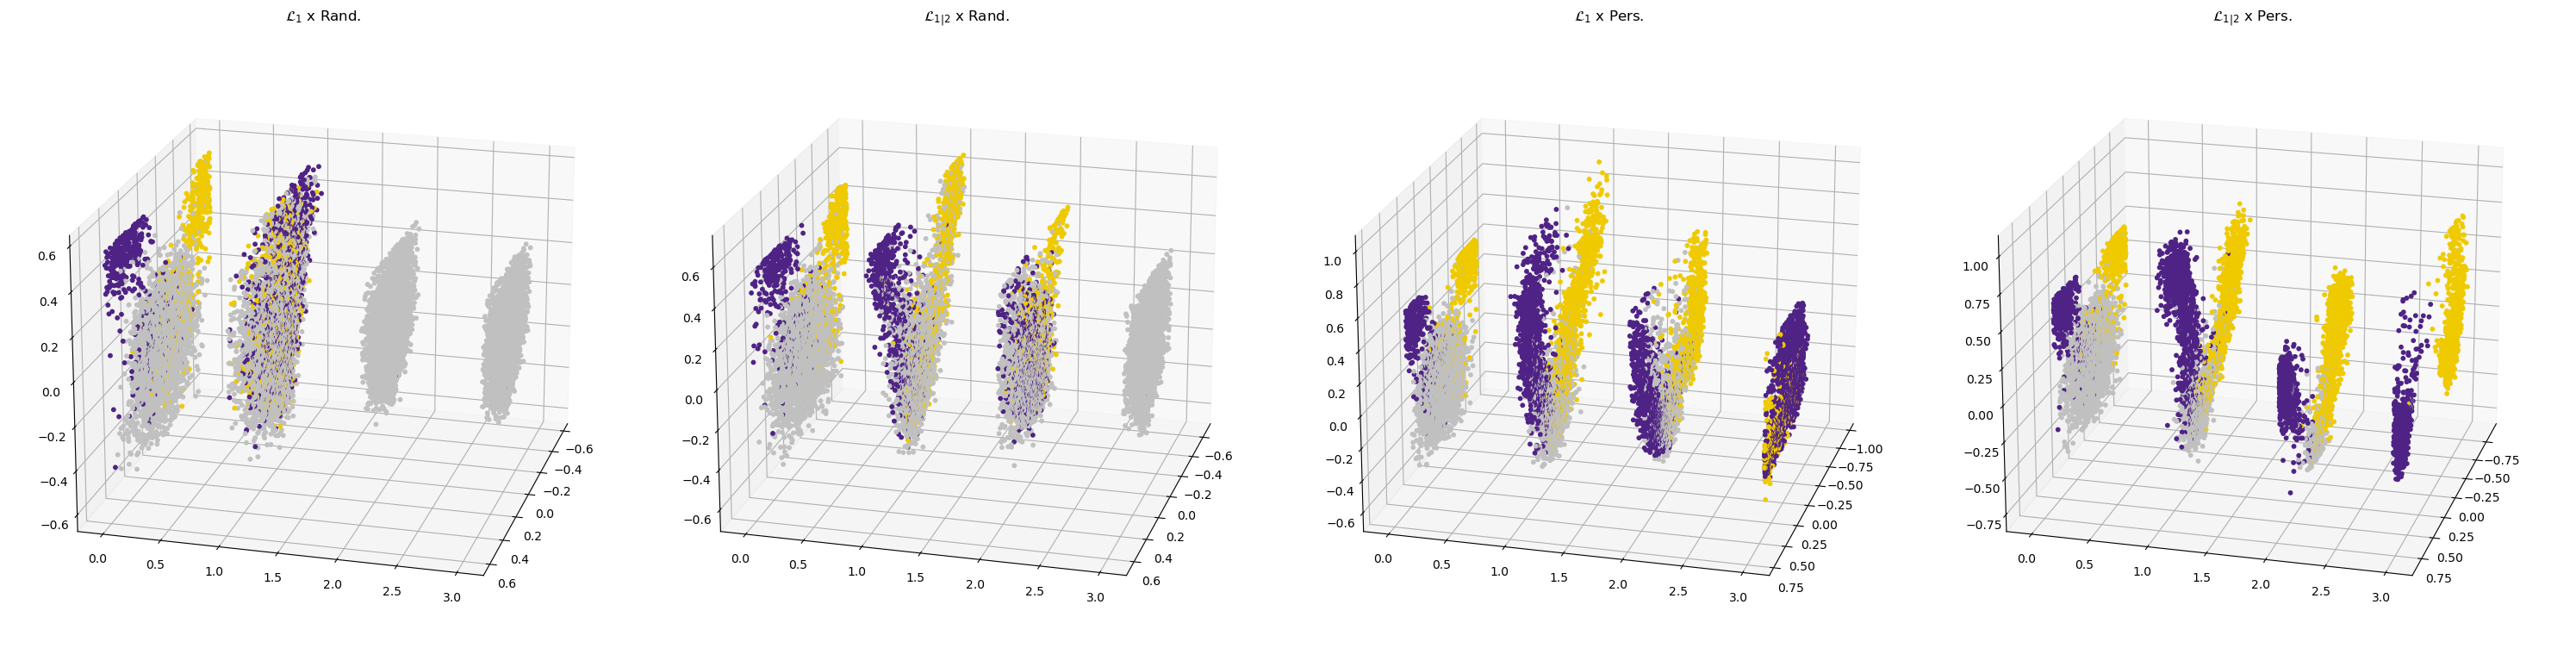

In [19]:

colors = {
    'red': np.array([239,202,0]) / 255.,
    'blue': np.array([79,34,133]) / 255.,
    'green': np.array([192, 192, 192]) / 255.
}

def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    
    test = s<m
    test = np.logical_and(test[:,0], test[:,1])
    #test = np.logical_not(test)

    return data[test,:], test

rej_outliers = True

target_epochs = [1, 25, 60, 100]

starting_epoch = 19
cur_target_epoch = 100
step_size = 20

print(community_info)

if target_epochs is not None:
    num_figures = len(target_epochs)
else:
    num_figures = int(cur_target_epoch / step_size)

fig = plt.figure("Detail", figsize=(30, 8 * num_figures))
axgrid = fig.add_gridspec(1, 4)

starting_community_mapper = bidict(nx.get_node_attributes(starting_user_graph, 'community'))
communities = np.array([colors[c] for c in list(starting_community_mapper.values())])

pcas = defaultdict(list)
for i, (label, direc) in enumerate(log_dirs.items()):
    user_embs = []
    epochs = target_epochs if target_epochs is not None else range(starting_epoch, cur_target_epoch, step_size)
    ax = fig.add_subplot(axgrid[0, i], projection='3d')
    ax.set_title('{}'.format(label))
    for j, epoch in enumerate(epochs):
        
        communities = np.array([colors[c] for c in list(starting_community_mapper.values())])
        user_graph = nx.read_gexf(os.path.join(direc[0], "user_graph_{}.gexf".format(epoch)), node_type=str)
        community_mapper = bidict(nx.get_node_attributes(user_graph, 'community'))
        for u, c in community_mapper.items():
            communities[int(u),:] = colors[community_info.loc[c]['label']]
        
            
        user_emb = torch.load(os.path.join(direc[0], 'user_emb_{}.pt'.format(epoch))).cpu().detach().numpy()
        user_embs.append(user_emb)
    
        pca = PCA(n_components=2)
        pca.fit(user_emb)
        
        user_emb_pca = pca.transform(user_emb)

        if rej_outliers:
            user_emb_pca, outliers = reject_outliers(user_emb_pca)
            cur_communities = communities[outliers]
        else:
            cur_communities = communities
            
        alpha = (j+1)/len(epochs)
        alpha = 1.0
        z_pos = [j] * user_emb_pca.shape[0]

        if i == 0:
            if j == 0:
                user_emb_pca[:,1] = user_emb_pca[:,1] * -1
            ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)            
        elif i == 1:
            if j in[0,1]:
                user_emb_pca[:,1] = user_emb_pca[:,1] * -1
            ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)
        elif i == 2:
            if j == 0:
                ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)                
            elif j == 1:
                user_emb_pca[:,1] = user_emb_pca[:,1] * -1
                ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)     
            else:
                ax.scatter(user_emb_pca[:, 0],z_pos,  user_emb_pca[:, 1], c=cur_communities, alpha=alpha, s=10)
        elif i == 3 and j == 0:
            ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)
        elif i == 3 and j == 1:
            user_emb_pca[:,1] = user_emb_pca[:,1] * -1
            ax.scatter(user_emb_pca[:, 1],z_pos,  user_emb_pca[:, 0], c=cur_communities, alpha=alpha, s=10)
        elif i == 3 and j in [2]:
            user_emb_pca[:,1] = user_emb_pca[:,1] * -1
            ax.scatter(user_emb_pca[:, 0],z_pos,  user_emb_pca[:, 1], c=cur_communities, alpha=alpha, s=10)            
        else:
            ax.scatter(user_emb_pca[:, 0],z_pos,  user_emb_pca[:, 1], c=cur_communities, alpha=alpha, s=10)
        #ax.scatter(user_emb_pca[:, 0],[j] * user_emb_pca.shape[0],  user_emb_pca[:, 1], c=cur_communities, alpha=1.0/(j+1)**2, s=10)
        pcas[label].append(user_emb_pca)
        
        ax.view_init(20,15)
plt.tight_layout()
plt.show()

       label  ideological  count
id                              
43195    red            1    520
43196  green            0   4100
43197   blue            1    520


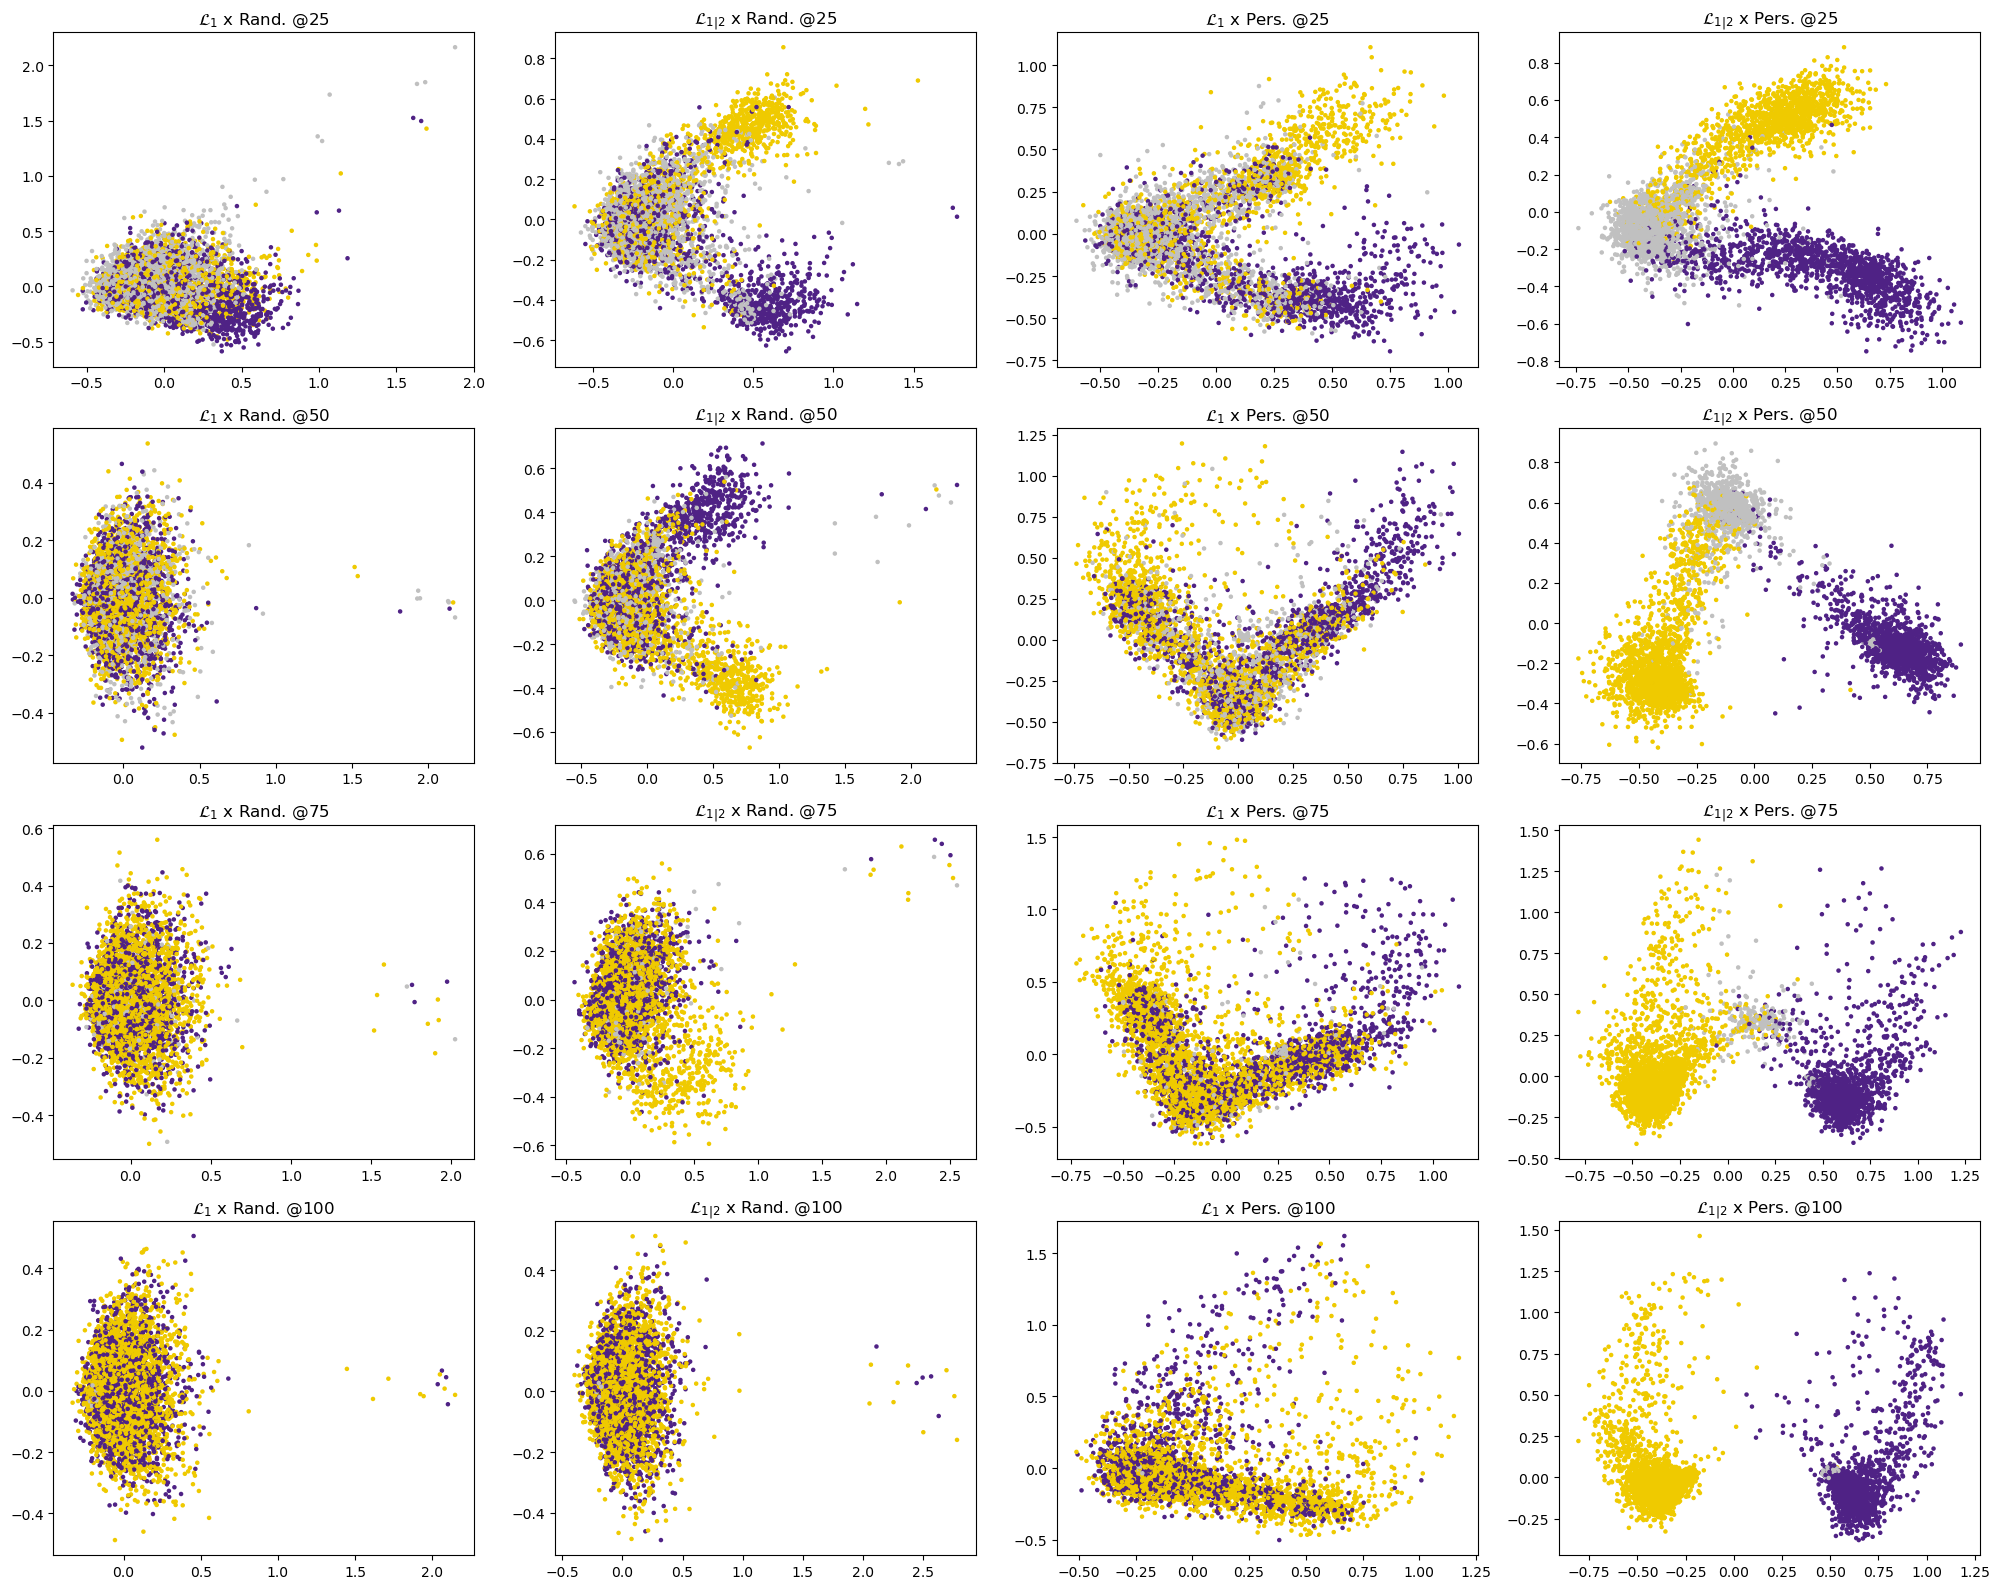

In [22]:
colors = {
    'red': np.array([239,202,0]) / 255.,
    'blue': np.array([79,34,133]) / 255.,
    'green': np.array([192, 192, 192]) / 255.
}

def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    
    test = s<m
    test = np.logical_and(test[:,0], test[:,1])
    #test = np.logical_not(test)

    return data[test,:], test

rej_outliers = False

target_epochs = [25, 50, 75, 100]
#target_epochs = None

starting_epoch = 1
cur_target_epoch = 80
step_size = 10

print(community_info)

if target_epochs is not None:
    num_figures = len(target_epochs)
else:
    num_figures = int(cur_target_epoch / step_size)

fig = plt.figure("Detail", figsize=(20, 4 * num_figures))
axgrid = fig.add_gridspec(num_figures, 4)

starting_community_mapper = bidict(nx.get_node_attributes(starting_user_graph, 'community'))
communities = np.array([colors[c] for c in list(starting_community_mapper.values())])

pcas = defaultdict(list)
for i, (label, direc) in enumerate(log_dirs.items()):
    user_embs = []
    epochs = target_epochs if target_epochs is not None else range(starting_epoch, cur_target_epoch, step_size)
    for j, epoch in enumerate(epochs):
        ax = fig.add_subplot(axgrid[j, i])
        ax.set_title('{} @{}'.format(label, epoch))
        
        user_graph = nx.read_gexf(os.path.join(log_dir[0], "user_graph_{}.gexf".format(epoch)), node_type=str)
        community_mapper = bidict(nx.get_node_attributes(user_graph, 'community'))
        for u, c in community_mapper.items():
            communities[int(u),:] = colors[community_info.loc[c]['label']]
        #communities = np.array([colors[community_info.loc[c]['label']] for c in list(community_mapper.values())])

        user_emb = torch.load(os.path.join(direc[0], 'user_emb_{}.pt'.format(epoch))).cpu().detach().numpy()
        user_embs.append(user_emb)
    
        pca = PCA(n_components=2)
        pca.fit(user_emb)
        
        user_emb_pca = pca.transform(user_emb)

        if rej_outliers:
            user_emb_pca, outliers = reject_outliers(user_emb_pca)
            cur_communities = communities[outliers]
        else:
            cur_communities = communities

        ax.scatter(user_emb_pca[:, 0], user_emb_pca[:, 1], c=cur_communities, alpha=1.0, s=5)
        pcas[label].append(user_emb_pca)
        
plt.tight_layout()
plt.show()

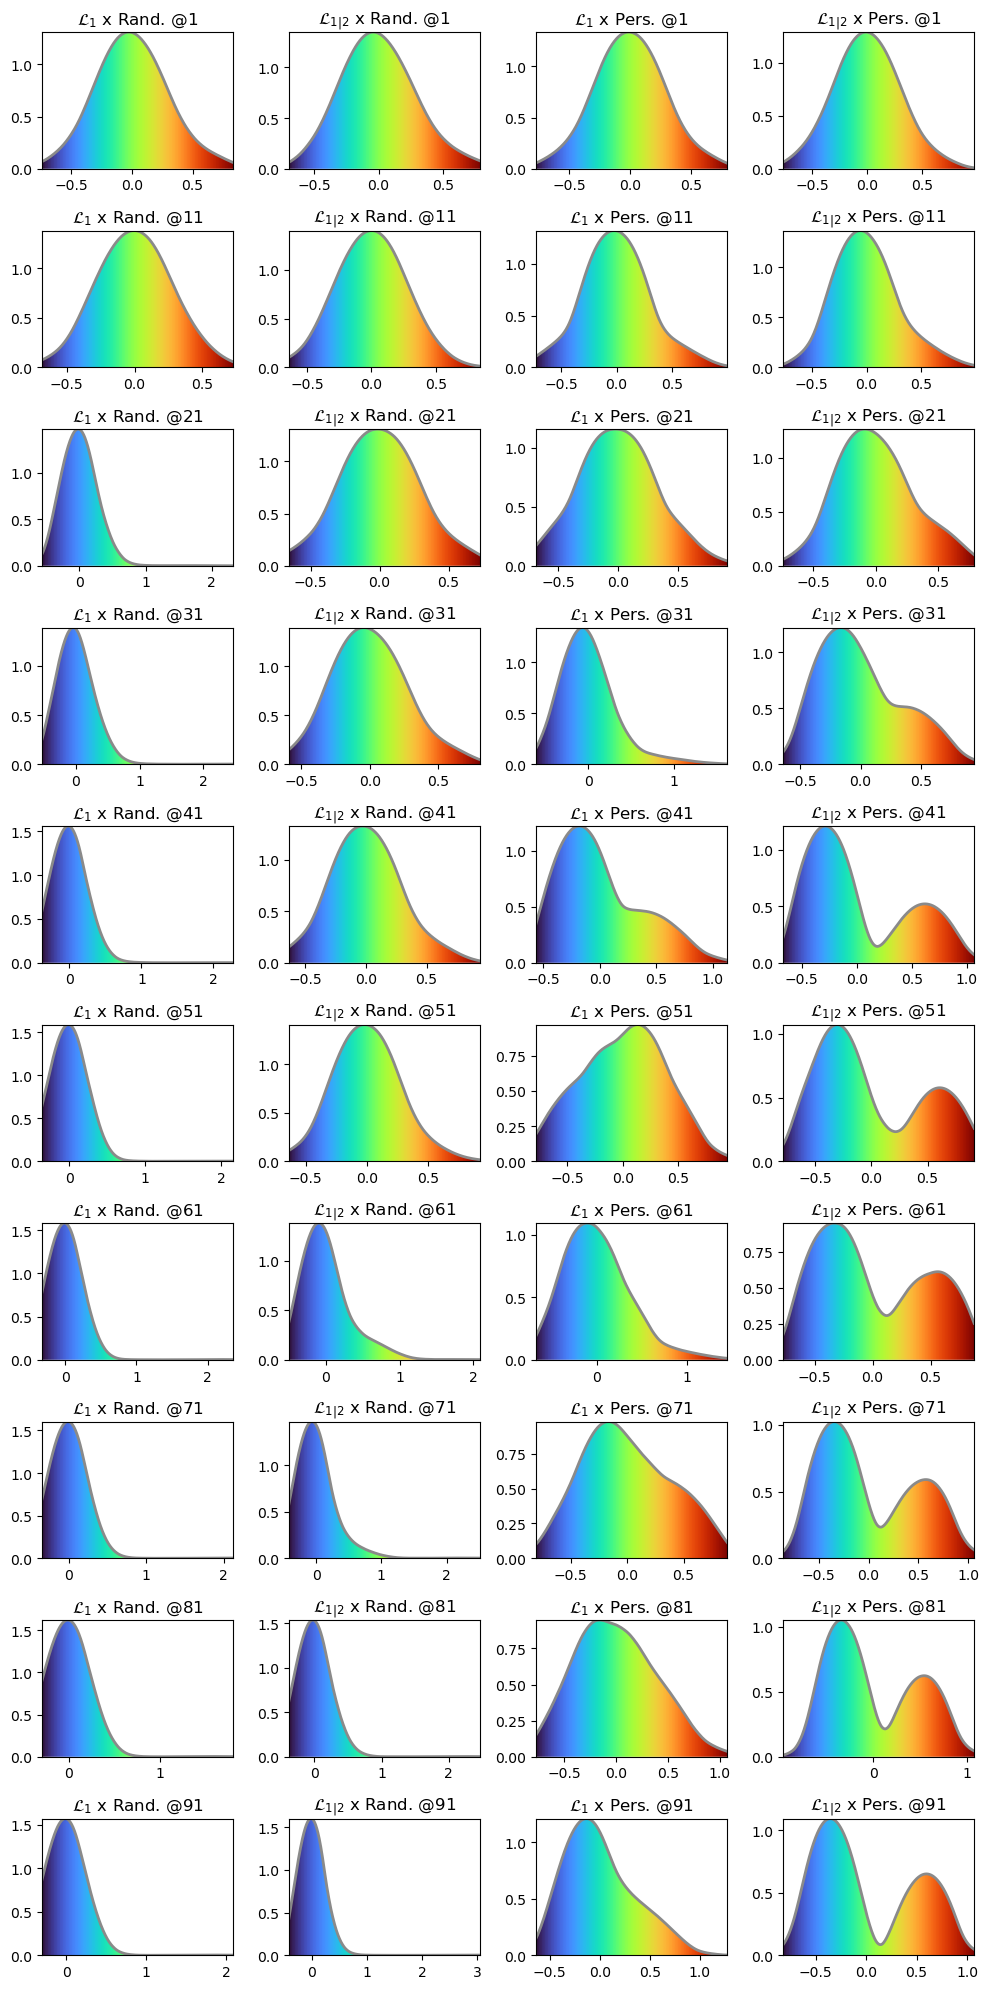

In [21]:
from matplotlib import cm

from scipy.special import kl_div
from scipy.spatial.distance import cdist

kernel = 'epanechnikov'
show_overview = True
starting_epoch = 1
cur_target_epoch = 100
step_size = 10
#labels=[y if y%3==0 else None for y in range(starting_epoch, cur_target_epoch)]

fig = plt.figure("Detail", figsize=(10,2 * (cur_target_epoch / step_size)))
axgrid = fig.add_gridspec(int(cur_target_epoch / step_size), 4)
lw = 2

pcas = defaultdict(list)
for i, (label, direc) in enumerate(log_dirs.items()):
    colors = []
    user_embs = []
    for j, epoch in enumerate(range(starting_epoch, cur_target_epoch, step_size)):
        ax = fig.add_subplot(axgrid[j, i])
        ax.set_title('{} @{}'.format(label, epoch))
        #user_graph = nx.read_gexf(os.path.join(direc[0], "user_graph_{}.gexf".format(epoch)), node_type=str)
        community_mapper = bidict(nx.get_node_attributes(starting_user_graph, 'community'))

        user_emb = torch.load(os.path.join(direc[0], 'user_emb_{}.pt'.format(epoch))).cpu().detach().numpy()
        user_embs.append(user_emb)
    
        pca = PCA(n_components=2)
        pca.fit(user_emb)
        
        user_emb_pca = pca.transform(user_emb)
        #user_emb_pca = user_emb_pca[:, 1]
        #user_emb_pca = np.reshape(user_emb_pca, [-1, 1])
 
        red_members = community_mapper.inverse['red']
        blue_members = community_mapper.inverse['blue']
        red_pc = np.take(user_emb_pca, red_members, axis=0)
        #red_pc = np.mean(red_pc, axis=0)
        blue_pc = np.take(user_emb_pca, blue_members, axis=0)
        #blue_pc = np.mean(blue_pc, axis=1)   
        
        d0 = np.mean(cdist(np.reshape(red_pc[:,0], [-1,1]), np.reshape(blue_pc[:,0], [-1,1])))
        d1 = np.mean(cdist(np.reshape(red_pc[:,1], [-1,1]), np.reshape(blue_pc[:,1], [-1,1])))
        
        if d0 > d1:
            user_emb_pca = np.reshape(user_emb_pca[:,0], [-1, 1])
        else:
            user_emb_pca = np.reshape(user_emb_pca[:,1], [-1, 1])
        
        
        pcas[label].append(np.reshape(user_emb_pca, [-1]))
        
        min_val = np.amin(user_emb_pca)
        max_val = np.amax(user_emb_pca)

        if show_overview:
            X_plot = np.linspace(min_val, max_val, 1000)[:, np.newaxis]

            kde = KernelDensity(kernel=kernel, bandwidth=0.4).fit(user_emb_pca)
            log_dens = kde.score_samples(X_plot)

            polygon = plt.fill_between(X_plot[:, 0], np.exp(log_dens), lw=0, color='none')

            verts = np.vstack([p.vertices for p in polygon.get_paths()])
            gradient = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='turbo', aspect='auto',
                                  extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()])
            gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)
            ax.plot(
                X_plot[:, 0],
                np.exp(log_dens),
                color='#8a8a8a',
                lw=lw,
                linestyle="-",
                label="kernel = '{0}'".format(kernel),
            )
plt.tight_layout()
plt.show()

In [152]:
max_explained_variance = 0.3466796
min_explained_variance = 0.16174737

In [33]:
max_explained_variance = 0.0
min_explained_variance = 1.0

$\mathcal{L}_1$ x Rand.
$\mathcal{L}_2$ x Rand.
[0.22992162]
[0.08958175]


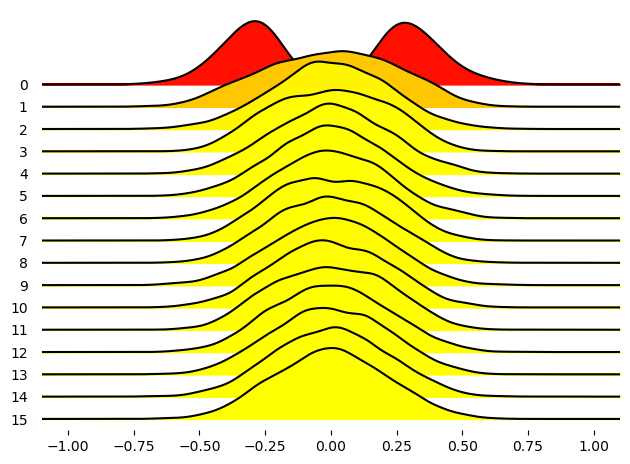

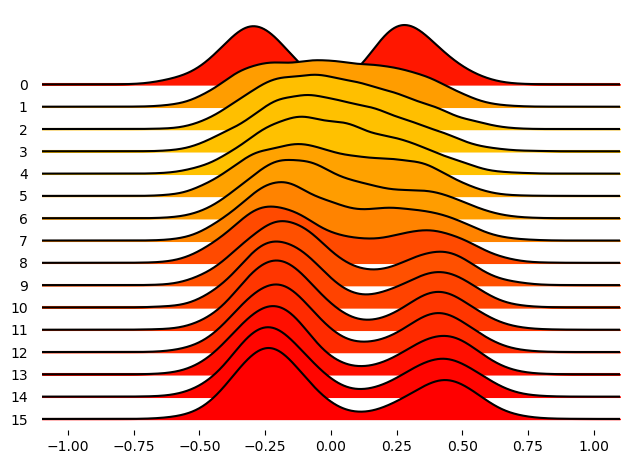

In [36]:
import joypy
from matplotlib import cm
starting_epoch = 1
cur_target_epoch = 80
step_size = 5
labels=[y if y%step_size==0 else None for y in range(starting_epoch, cur_target_epoch)]

x = np.linspace(0.0, 1.0, 100)
rgb = plt.colormaps['autumn'](x)[np.newaxis, :, :3]
len_rgb = rgb.shape[1]

for i, (label, direc) in enumerate(log_dirs.items()):
    #ax = fig.add_subplot(axgrid[int(i / 2), i % 2])
    #ax.set_title(label)
    
    pcas = []
    print(label)
    colors = []
    for epoch in range(starting_epoch, cur_target_epoch, step_size):
        user_graph = nx.read_gexf(os.path.join(direc[0], "user_graph_{}.gexf".format(epoch)), node_type=str)
        community_mapper = bidict(nx.get_node_attributes(user_graph, 'community'))

        user_emb = torch.load(os.path.join(direc[0], 'user_emb_{}.pt'.format(epoch))).cpu().detach().numpy()

        pca = PCA(n_components=1)
        pca.fit(user_emb)
        
        explained_variance = pca.explained_variance_ * 2
        if explained_variance > max_explained_variance:
            max_explained_variance = explained_variance
            
        if explained_variance < min_explained_variance:
            min_explained_variance = explained_variance
        
        frac = (explained_variance - min_explained_variance + 0.000001) / (max_explained_variance - min_explained_variance + 0.000001)
        color = min(len_rgb - int(frac * len_rgb), len_rgb-1)
        colors.append(rgb[0,color])

        user_emb_pca = pca.transform(user_emb)
        user_emb_pca = np.reshape(user_emb_pca, [-1])
        pcas.append(user_emb_pca)

    df = pd.DataFrame(pcas)
    df = df.T
    fig, axes = joypy.joyplot(df, color=colors, x_range=(-1.1,1.1), labels=labels)
    #fig, axes = joypy.joyplot(df, color=colors, labels=labels)
    
    save_path = os.path.join(parent_dir, 'log', dataset, 'evaluation', 'joyplot_{}'.format(label))
    fig.savefig(save_path, dpi=300)
    

print(max_explained_variance)
print(min_explained_variance)

## 4. Community Overview

In [ ]:
def plot_community_overview(column_name):
    fig = plt.figure(column_name, figsize=(10, 15))

    axgrid = fig.add_gridspec(5, 2)
    x, y = 0,0

    for condition, log_df in logs.items():
        sub_logs = log_df.iloc[:target_epoch]
        size_cols = [c for c in sub_logs.columns if column_name in c]
        size = sub_logs[size_cols]

        ax = fig.add_subplot(axgrid[y, x])
        ax.set_title(condition)

        ax.plot(size, marker="o", label=size.columns)
        ax.legend()

        y += x
        x = (y + 1) % 2
    fig.suptitle(column_name, fontsize=16)
    fig.tight_layout()
    plt.show()

plot_community_overview('size')
plot_community_overview('homophily')